# Main Project Notebook

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
# Needed for training
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import random_split, DataLoader
from torch.utils.data.dataset import Subset
# Models
from models_part1 import FinalClassifier , MNISTAutoencoder, CIFAR10Autoencoder
from models_part2 import MNISTClassifyingAutoencoder,CIFAR10ClassifyingAutoencoder
from models_part3 import NTXentLoss,MnistSimCLR,Cifar10SimCLR
from models_testing import  plot_accuracies,plot_losses,test_classifier,test_classifyingAutoEncoder
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# MNIST

## Preparing data

In [14]:
mnist_path = "./mnist_data"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307], std=[0.3081])
])

train_dataset = torchvision.datasets.MNIST(
    root=mnist_path,  
    train=True,       
    transform=transform,  # Apply transformations here
    download=True     
)

test_dataset = torchvision.datasets.MNIST(
    root=mnist_path,
    train=False,  
    transform=transform,  # Apply same transformations for test data
    download=True
)

print("MNIST dataset downloaded successfully!")

MNIST dataset downloaded successfully!


In [15]:
train_size = 50_000
val_size = 10_000

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")


batch_size = 64

# Create DataLoaders
mnist_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 1)
mnist_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)
mnist_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)

print("DataLoaders created successfully!")

images, labels = next(iter(mnist_train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels[:5]}")

Train size: 50000, Validation size: 10000, Test size: 10000
DataLoaders created successfully!
Batch shape: torch.Size([64, 1, 28, 28]), Labels: tensor([9, 5, 6, 1, 8])


## 1.2.1

In [16]:
# Model initialization
model = MNISTAutoencoder(latent_dim=128).to(device)

train_losses,val_losses = model.train_autoencoder(train_loader= mnist_train_loader,
                       val_loader=mnist_val_loader,
                       num_epochs=25,
                       learning_rate=1e-4)

Epoch [1/25], Time: 9.01s, Train Loss: 0.7090, Val Loss: 0.6874, LR: 0.000100
Epoch [2/25], Time: 8.92s, Train Loss: 0.6503, Val Loss: 0.5960, LR: 0.000100
Epoch [3/25], Time: 8.90s, Train Loss: 0.5923, Val Loss: 0.5794, LR: 0.000100
Epoch [4/25], Time: 8.89s, Train Loss: 0.5832, Val Loss: 0.5738, LR: 0.000100
Epoch [5/25], Time: 8.90s, Train Loss: 0.5794, Val Loss: 0.5711, LR: 0.000100
Epoch [6/25], Time: 9.03s, Train Loss: 0.5771, Val Loss: 0.5690, LR: 0.000100
Epoch [7/25], Time: 8.99s, Train Loss: 0.5756, Val Loss: 0.5676, LR: 0.000100
Epoch [8/25], Time: 9.01s, Train Loss: 0.5744, Val Loss: 0.5665, LR: 0.000100
Epoch [9/25], Time: 9.02s, Train Loss: 0.5735, Val Loss: 0.5656, LR: 0.000100
Epoch [10/25], Time: 9.20s, Train Loss: 0.5727, Val Loss: 0.5650, LR: 0.000025
Epoch [11/25], Time: 9.48s, Train Loss: 0.5720, Val Loss: 0.5644, LR: 0.000025
Epoch [12/25], Time: 10.67s, Train Loss: 0.5717, Val Loss: 0.5642, LR: 0.000025
Epoch [13/25], Time: 9.95s, Train Loss: 0.5716, Val Loss: 0.

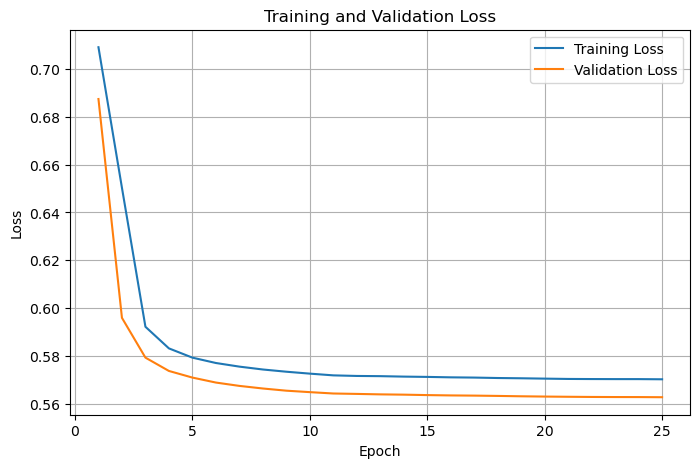

In [17]:
plot_losses(train_losses = train_losses, val_losses = val_losses)

In [18]:
pretrained_encoder = model.encoder
for param in pretrained_encoder.parameters():
    param.requires_grad = False  # Ensure encoder is frozen
classifier = FinalClassifier(latent_dim=128)
train_losses, train_accuracies, val_accuracies = classifier.fit_classifier(encoder = pretrained_encoder,
                                                                           train_loader =  mnist_train_loader,
                                                                           val_loader = mnist_val_loader,
                                                                           num_epochs=15, learning_rate=1e-3)


Epoch [1/15], Time: 9.40s, Train Loss: 0.1826, Train Accuracy: 94.54%, Val Accuracy: 97.12%, LR: 0.001000
Epoch [2/15], Time: 9.22s, Train Loss: 0.0944, Train Accuracy: 97.05%, Val Accuracy: 97.31%, LR: 0.001000
Epoch [3/15], Time: 9.22s, Train Loss: 0.0729, Train Accuracy: 97.61%, Val Accuracy: 97.64%, LR: 0.001000
Epoch [4/15], Time: 9.24s, Train Loss: 0.0607, Train Accuracy: 98.06%, Val Accuracy: 97.73%, LR: 0.001000
Epoch [5/15], Time: 9.21s, Train Loss: 0.0537, Train Accuracy: 98.26%, Val Accuracy: 97.96%, LR: 0.001000
Epoch [6/15], Time: 9.55s, Train Loss: 0.0454, Train Accuracy: 98.48%, Val Accuracy: 98.18%, LR: 0.001000
Epoch [7/15], Time: 9.55s, Train Loss: 0.0410, Train Accuracy: 98.63%, Val Accuracy: 98.04%, LR: 0.001000
Epoch [8/15], Time: 9.33s, Train Loss: 0.0383, Train Accuracy: 98.74%, Val Accuracy: 97.94%, LR: 0.001000
Epoch [9/15], Time: 9.44s, Train Loss: 0.0363, Train Accuracy: 98.74%, Val Accuracy: 98.21%, LR: 0.001000
Epoch [10/15], Time: 9.15s, Train Loss: 0.0310

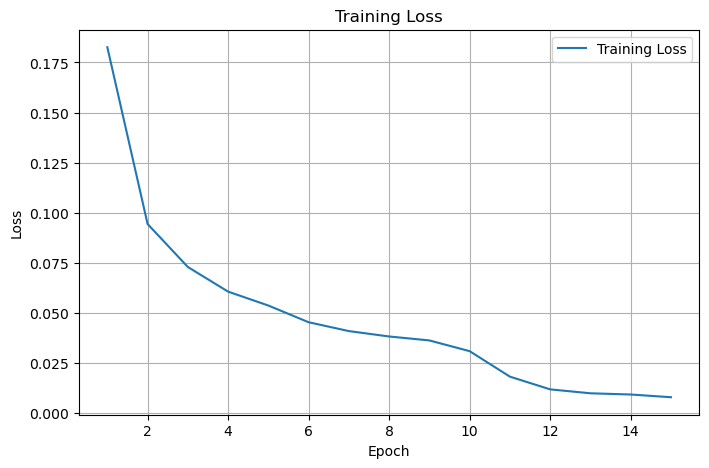

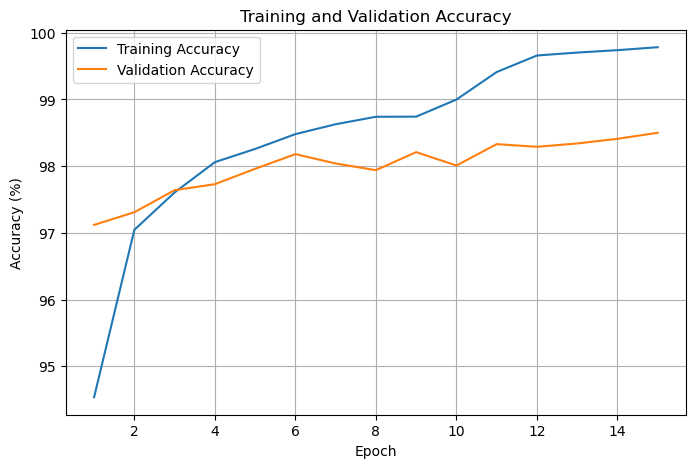

In [19]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [20]:
test_classifier(encoder=pretrained_encoder,
                classifier=classifier,
                test_loader=mnist_test_loader)

Test Accuracy: 98.55%


## 1.2.2

In [11]:
# Model initialization
model = MNISTClassifyingAutoencoder(latent_dim=128).to(device)

train_losses, train_accuracies, val_accuracies = model.train_autoencoder(train_loader= mnist_train_loader,
                       val_loader=mnist_val_loader,
                       num_epochs=15,
                       learning_rate=1e-4)

Epoch [1/15], Time: 10.17s, Train Loss: 0.3248, Train Accuracy: 91.08%, Val Accuracy: 96.77%, LR: 0.000100
Epoch [2/15], Time: 9.94s, Train Loss: 0.0965, Train Accuracy: 97.21%, Val Accuracy: 97.80%, LR: 0.000100
Epoch [3/15], Time: 9.78s, Train Loss: 0.0624, Train Accuracy: 98.12%, Val Accuracy: 98.05%, LR: 0.000100
Epoch [4/15], Time: 9.81s, Train Loss: 0.0447, Train Accuracy: 98.61%, Val Accuracy: 98.25%, LR: 0.000100
Epoch [5/15], Time: 9.91s, Train Loss: 0.0331, Train Accuracy: 98.95%, Val Accuracy: 98.30%, LR: 0.000100
Epoch [6/15], Time: 9.90s, Train Loss: 0.0266, Train Accuracy: 99.19%, Val Accuracy: 98.63%, LR: 0.000100
Epoch [7/15], Time: 10.18s, Train Loss: 0.0203, Train Accuracy: 99.39%, Val Accuracy: 98.57%, LR: 0.000100
Epoch [8/15], Time: 9.76s, Train Loss: 0.0171, Train Accuracy: 99.48%, Val Accuracy: 98.50%, LR: 0.000100
Epoch [9/15], Time: 9.84s, Train Loss: 0.0141, Train Accuracy: 99.54%, Val Accuracy: 98.60%, LR: 0.000100
Epoch [10/15], Time: 9.87s, Train Loss: 0.01

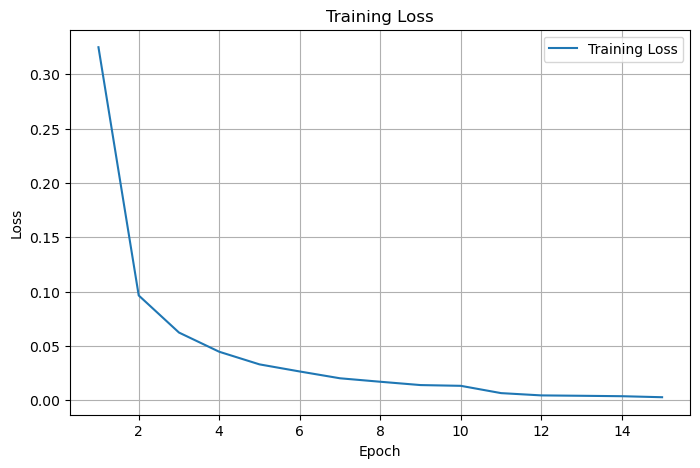

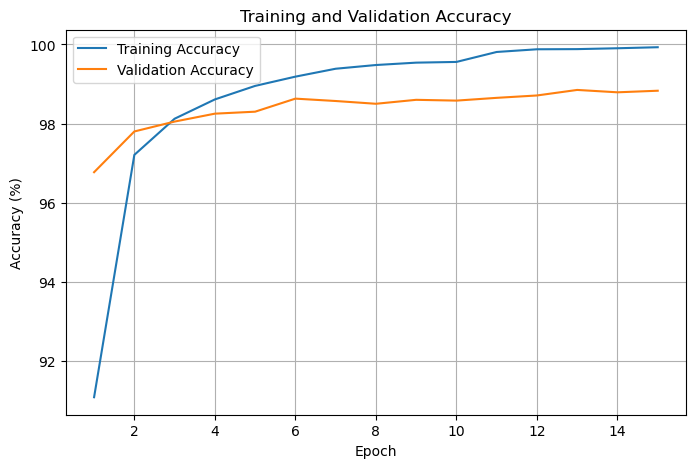

In [12]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [13]:
test_classifyingAutoEncoder(classifier=model,
                            test_loader=mnist_test_loader)

Test Accuracy: 98.71%


## 1.2.3

## Data preparation

In [33]:
mnist_path = "./mnist_data"

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.1307], std=[0.3081])
])


train_dataset = torchvision.datasets.MNIST(
    root=mnist_path,  
    train=True,       
    transform=transform,  # Apply transformations here
    download=True     
)

test_dataset = torchvision.datasets.MNIST(
    root=mnist_path,
    train=False,  
    transform=transform,  # Apply same transformations for test data
    download=True
)

print("MNIST dataset downloaded successfully!")

MNIST dataset downloaded successfully!


In [34]:
train_size = 50_000
val_size = 10_000
batch_size = 1024


train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

# Create DataLoaders
mnist_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 1)
mnist_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)
mnist_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)

print("DataLoaders created successfully!")

# images, labels = next(iter(mnist_train_loader))
# print(f"Batch shape: {images.shape}, Labels: {labels[:5]}")

Train size: 50000, Validation size: 10000, Test size: 10000
DataLoaders created successfully!


In [35]:
model = MnistSimCLR(latent_dim=128,dropout_prob=0.1,temperature = 0.1).to(device)
train_losses,val_losses = model.train_autoencoder(train_loader= mnist_train_loader,
                       val_loader=mnist_val_loader,
                       num_epochs=25,
                       learning_rate=1e-3)


Epoch [1/25], Time: 7.81s, Train Loss: 7.6092, Val Loss: 7.3809, LR: 0.001000
Epoch [2/25], Time: 7.23s, Train Loss: 7.4026, Val Loss: 6.8395, LR: 0.001000
Epoch [3/25], Time: 7.42s, Train Loss: 7.2519, Val Loss: 6.5323, LR: 0.001000
Epoch [4/25], Time: 7.20s, Train Loss: 6.8513, Val Loss: 5.3621, LR: 0.001000
Epoch [5/25], Time: 7.04s, Train Loss: 6.5302, Val Loss: 5.1067, LR: 0.001000
Epoch [6/25], Time: 7.27s, Train Loss: 6.2887, Val Loss: 4.9205, LR: 0.001000
Epoch [7/25], Time: 7.67s, Train Loss: 6.0144, Val Loss: 4.6784, LR: 0.001000
Epoch [8/25], Time: 7.35s, Train Loss: 5.5087, Val Loss: 4.1851, LR: 0.001000
Epoch [9/25], Time: 7.65s, Train Loss: 5.2860, Val Loss: 3.8857, LR: 0.001000
Epoch [10/25], Time: 7.84s, Train Loss: 5.1993, Val Loss: 3.8105, LR: 0.000100
Epoch [11/25], Time: 7.51s, Train Loss: 4.8253, Val Loss: 3.6537, LR: 0.000100
Epoch [12/25], Time: 7.56s, Train Loss: 4.6502, Val Loss: 3.5627, LR: 0.000100
Epoch [13/25], Time: 7.68s, Train Loss: 4.7014, Val Loss: 3.5

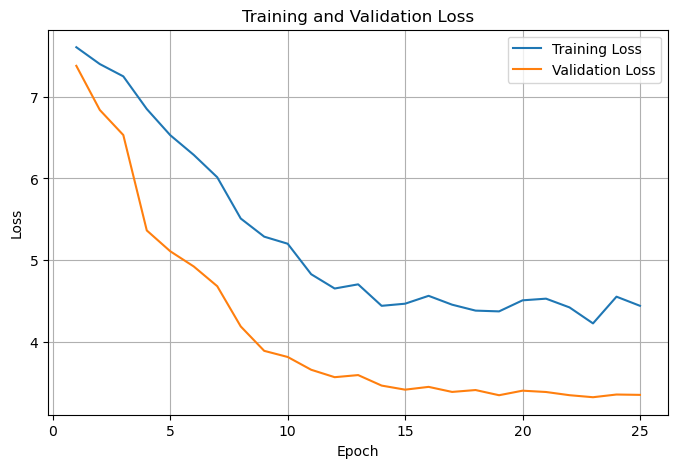

In [36]:
plot_losses(train_losses = train_losses, val_losses = val_losses)

In [37]:
pretrained_encoder = model.encoder
for param in pretrained_encoder.parameters():
    param.requires_grad = False  # Ensure encoder is frozen
classifier = FinalClassifier(latent_dim=128)
train_losses, train_accuracies, val_accuracies = classifier.fit_classifier(encoder = pretrained_encoder,
                                                                           train_loader = mnist_train_loader,
                                                                           val_loader = mnist_val_loader,
                                                                           num_epochs=15, learning_rate=1e-3)


Epoch [1/15], Time: 7.60s, Train Loss: 0.6736, Train Accuracy: 79.85%, Val Accuracy: 91.15%, LR: 0.001000
Epoch [2/15], Time: 8.00s, Train Loss: 0.2674, Train Accuracy: 91.85%, Val Accuracy: 93.32%, LR: 0.001000
Epoch [3/15], Time: 7.77s, Train Loss: 0.2091, Train Accuracy: 93.45%, Val Accuracy: 94.77%, LR: 0.001000
Epoch [4/15], Time: 8.16s, Train Loss: 0.1840, Train Accuracy: 94.18%, Val Accuracy: 94.44%, LR: 0.001000
Epoch [5/15], Time: 7.91s, Train Loss: 0.1682, Train Accuracy: 94.61%, Val Accuracy: 94.82%, LR: 0.001000
Epoch [6/15], Time: 7.89s, Train Loss: 0.1560, Train Accuracy: 94.97%, Val Accuracy: 95.24%, LR: 0.001000
Epoch [7/15], Time: 7.96s, Train Loss: 0.1482, Train Accuracy: 95.19%, Val Accuracy: 95.65%, LR: 0.001000
Epoch [8/15], Time: 7.92s, Train Loss: 0.1402, Train Accuracy: 95.50%, Val Accuracy: 95.69%, LR: 0.001000
Epoch [9/15], Time: 7.70s, Train Loss: 0.1363, Train Accuracy: 95.54%, Val Accuracy: 95.80%, LR: 0.001000
Epoch [10/15], Time: 8.03s, Train Loss: 0.1324

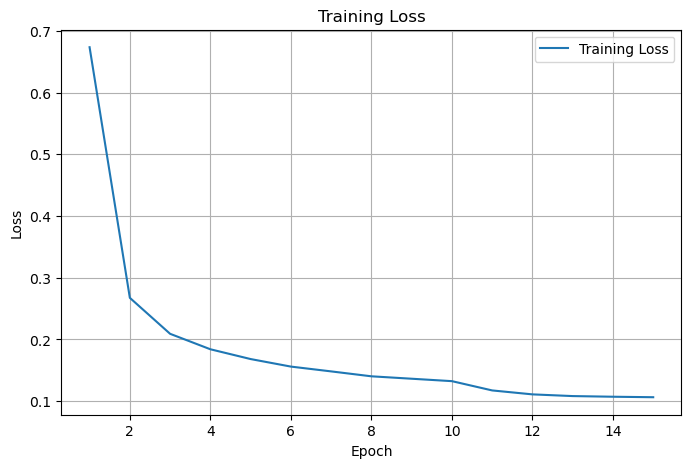

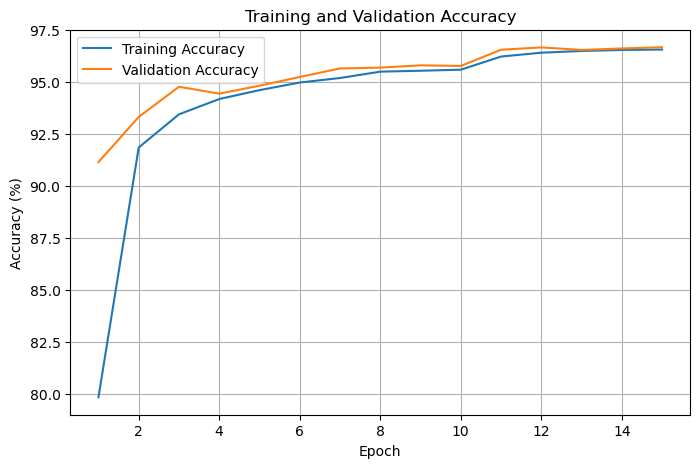

In [38]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [39]:
test_classifier(encoder=pretrained_encoder,
                classifier=classifier,
                test_loader=mnist_test_loader)

Test Accuracy: 96.71%


# Cifar10

## Preparing data

In [8]:
cifar10_path = "./cifar10_data"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

c10_full_train_dataset = torchvision.datasets.CIFAR10(
    root=cifar10_path,  
    train=True,       
    transform=transform,
    download=True     
)

c10_test_dataset = torchvision.datasets.CIFAR10(
    root=cifar10_path,
    train=False,  
    transform=transform,
    download=True
)

print("CIFAR-10 dataset downloaded successfully!")

Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 dataset downloaded successfully!


In [9]:
train_size = 40_000
val_size = 10_000

c10_train_dataset, c10_val_dataset = random_split(c10_full_train_dataset, [train_size, val_size])

# Check dataset sizes
print(f"Train size: {len(c10_train_dataset)}, Validation size: {len(c10_val_dataset)}, Test size: {len(c10_test_dataset)}")

# Define batch size
batch_size = 64

# Create DataLoaders
c10_train_loader = DataLoader(c10_train_dataset, batch_size=batch_size, shuffle=True, num_workers = 1)
c10_val_loader = DataLoader(c10_val_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)
c10_test_loader = DataLoader(c10_test_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)

print("DataLoaders created successfully!")

# Get a batch of images and labels from the train_loader
images, labels = next(iter(c10_train_loader))
print(f"Batch shape: {images.shape}, Labels (first 5): {labels[:5]}")

Train size: 40000, Validation size: 10000, Test size: 10000
DataLoaders created successfully!
Batch shape: torch.Size([64, 3, 32, 32]), Labels (first 5): tensor([6, 7, 3, 7, 1])


## 1.2.1

In [ ]:
model = CIFAR10Autoencoder(latent_dim=128, dropout_prob = 0.1).to(device)
train_losses,val_losses = model.train_autoencoder(train_loader = c10_train_loader,
                        val_loader = c10_val_loader,
                        num_epochs=20,
                        learning_rate= 1e-3,
                        weight_decay= 1e-3)

In [ ]:
plot_losses(train_losses = train_losses, val_losses = val_losses)

In [ ]:
for param in model.encoder.parameters():
    param.requires_grad = False  # Ensure encoder is frozen
pretrained_encoder = model.encoder
classifier = FinalClassifier(latent_dim=128)
train_losses, train_accuracies, val_accuracies = classifier.fit_classifier(encoder = pretrained_encoder,
                                                                           train_loader =  c10_train_loader,
                                                                           val_loader = c10_val_loader,
                                                                           num_epochs=20, learning_rate=1e-3)

In [ ]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [ ]:
test_classifier(encoder=pretrained_encoder,
                classifier=classifier,
                test_loader=c10_test_loader)

## 1.2.2

In [ ]:
# Model initialization
model = CIFAR10ClassifyingAutoencoder(latent_dim=128,
                                      dropout_prob=0.1).to(device)

train_losses, train_accuracies, val_accuracies = model.train_autoencoder(train_loader= c10_train_loader,
                                                                         val_loader=c10_val_loader,
                                                                         num_epochs=25,
                                                                         learning_rate=1e-4,
                                                                         weight_decay= 1e-3)

In [ ]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [ ]:
test_classifyingAutoEncoder(classifier=model,
                            test_loader=c10_test_loader)

## 1.2.3

# Data Preparation

In [3]:
cifar10_path = "./cifar10_data"

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]), #moved to model code for color jitter compatability
])

c10_full_train_dataset = torchvision.datasets.CIFAR10(
    root=cifar10_path,  
    train=True,       
    transform=transform,
    download=True     
)

c10_test_dataset = torchvision.datasets.CIFAR10(
    root=cifar10_path,
    train=False,  
    transform=transform,
    download=True
)

print("CIFAR-10 dataset downloaded successfully!")

Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 dataset downloaded successfully!


In [4]:
train_size = 40_000
val_size = 10_000
batch_size = 512

c10_train_dataset, c10_val_dataset = random_split(c10_full_train_dataset, [train_size, val_size])

# Check dataset sizes
print(f"Train size: {len(c10_train_dataset)}, Validation size: {len(c10_val_dataset)}, Test size: {len(c10_test_dataset)}")



# Create DataLoaders
c10_train_loader = DataLoader(c10_train_dataset, batch_size=batch_size, shuffle=True, num_workers = 1)
c10_val_loader = DataLoader(c10_val_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)
c10_test_loader = DataLoader(c10_test_dataset, batch_size=batch_size, shuffle=False, num_workers = 1)

print("DataLoaders created successfully!")

# Get a batch of images and labels from the train_loader
images, labels = next(iter(c10_train_loader))
print(f"Batch shape: {images.shape}, Labels (first 5): {labels[:5]}")

Train size: 40000, Validation size: 10000, Test size: 10000
DataLoaders created successfully!
Batch shape: torch.Size([512, 3, 32, 32]), Labels (first 5): tensor([7, 5, 1, 4, 1])


In [5]:
model = Cifar10SimCLR(latent_dim=128,
                      dropout_prob=0.1,
                      temperature=0.1).to(device)
train_losses,val_losses = model.train_autoencoder(train_loader = c10_train_loader,
                        val_loader = c10_val_loader,
                        num_epochs=20,
                        learning_rate=1e-3,
                        weight_decay= 1e-3)

Initializing weights ....
Initializing weights DONE
Epoch [1/20], Time: 65.06s, Train Loss: 2.6630, Val Loss: 0.7414, LR: 0.001000


KeyboardInterrupt: 

In [ ]:
plot_losses(train_losses = train_losses, val_losses = val_losses)

In [ ]:
pretrained_encoder = model.encoder
for param in pretrained_encoder.parameters():
    param.requires_grad = False  # Ensure encoder is frozen
classifier = FinalClassifier(latent_dim=128)
train_losses, train_accuracies, val_accuracies = classifier.fit_classifier(encoder = pretrained_encoder,
                                                                           train_loader =  c10_train_loader,
                                                                           val_loader = c10_val_loader,
                                                                           num_epochs=20, 
                                                                           learning_rate=1e-3)

In [ ]:
plot_losses(train_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [ ]:
test_classifier(encoder=pretrained_encoder,
                classifier=classifier,
                test_loader=c10_test_loader)